# [从零开始学习NLP：使用字符集RNN对行吗进行分类](https://pytorch.ac.cn/tutorials/intermediate/char_rnn_classification_tutorial.html)

我们将构建和训练一个基本的字符级循环神经网络 (RNN) 来对单词进行分类。本教程以及另外两个自然语言处理 (NLP)“从零开始”教程，从零开始学习 NLP：使用字符级 RNN 生成姓名和从零开始学习 NLP：使用序列到序列网络和注意力机制进行翻译，展示了如何预处理数据以建模 NLP。特别是，这些教程没有使用许多torchtext的便捷函数，因此您可以看到在底层如何预处理以建模 NLP。

字符级 RNN 将单词作为一系列字符读取 - 在每个步骤输出预测和“隐藏状态”，将其先前的隐藏状态馈送到每个下一步。我们将最终预测作为输出，即单词所属的类别。

具体来说，我们将根据拼写对来自 18 种语言的几千个姓氏进行训练，并预测姓名来自哪种语言。

## 准备数据
data/names目录中包含 18 个文本文件，命名为[语言].txt。每个文件都包含一堆名称，每行一个名称，大部分是罗马化的（但我们仍然需要从 Unicode 转换为 ASCII）。

我们最终会得到一个字典，其中包含按语言列出的名称列表，{语言: [名称 ...]}。通用变量“类别”和“行”（在我们的例子中是语言和名称）用于以后的可扩展性。

In [32]:
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [33]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [34]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

readLines('data/names/Chinese.txt')

['Ang',
 'AuYong',
 'Bai',
 'Ban',
 'Bao',
 'Bei',
 'Bian',
 'Bui',
 'Cai',
 'Cao',
 'Cen',
 'Chai',
 'Chaim',
 'Chan',
 'Chang',
 'Chao',
 'Che',
 'Chen',
 'Cheng',
 'Cheung',
 'Chew',
 'Chieu',
 'Chin',
 'Chong',
 'Chou',
 'Chu',
 'Cui',
 'Dai',
 'Deng',
 'Ding',
 'Dong',
 'Dou',
 'Duan',
 'Eng',
 'Fan',
 'Fei',
 'Feng',
 'Foong',
 'Fung',
 'Gan',
 'Gauk',
 'Geng',
 'Gim',
 'Gok',
 'Gong',
 'Guan',
 'Guang',
 'Guo',
 'Gwock',
 'Han',
 'Hang',
 'Hao',
 'Hew',
 'Hiu',
 'Hong',
 'Hor',
 'Hsiao',
 'Hua',
 'Huan',
 'Huang',
 'Hui',
 'Huie',
 'Huo',
 'Jia',
 'Jiang',
 'Jin',
 'Jing',
 'Joe',
 'Kang',
 'Kau',
 'Khoo',
 'Khu',
 'Kong',
 'Koo',
 'Kwan',
 'Kwei',
 'Kwong',
 'Lai',
 'Lam',
 'Lang',
 'Lau',
 'Law',
 'Lew',
 'Lian',
 'Liao',
 'Lim',
 'Lin',
 'Ling',
 'Liu',
 'Loh',
 'Long',
 'Loong',
 'Luo',
 'Mah',
 'Mai',
 'Mak',
 'Mao',
 'Mar',
 'Mei',
 'Meng',
 'Miao',
 'Min',
 'Ming',
 'Moy',
 'Mui',
 'Nie',
 'Niu',
 'OuYang',
 'OwYang',
 'Pan',
 'Pang',
 'Pei',
 'Peng',
 'Ping',
 'Qian',
 '

In [35]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)
print(all_categories)
print(category_lines['Italian'][:5])


18
['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 将名称转换为张量
现在我们已经组织好了所有名称，我们需要将它们转换为张量才能使用它们。

为了表示单个字母，我们使用大小为<1 x n_letters>的“one-hot 向量”。one-hot 向量用 0 填充，当前字母的索引处为 1，例如"b" = <0 1 0 0 0 ...>。

为了组成一个单词，我们将一堆这样的向量连接成一个二维矩阵<line_length x 1 x n_letters>。

额外增加的一个维度是因为 PyTorch 假设所有内容都是成批处理的 - 我们在这里只使用了一个大小为 1 的批次。

In [36]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
print(all_letters)
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letter> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('a'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [37]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('lines').size())
print(lineToTensor('lines'))

torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

## 创建网络
在自动微分之前，在 Torch 中创建循环神经网络需要在多个时间步长上克隆一个层的参数。这些层保存着隐藏状态和梯度，现在完全由图本身处理。这意味着您可以以一种非常“纯粹”的方式实现 RNN，就像常规的前馈层一样。

这个 RNN 模块实现了一个“普通 RNN”，它只有 3 个线性层，作用于输入和隐藏状态，输出后有一个LogSoftmax层。

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=57, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


为了运行该网络的一个步骤，我们需要传递一个输入（在我们的例子中，是当前字母的张量）和一个先前的隐藏状态（我们首先将其初始化为零）。我们将得到输出（每种语言的概率）和下一个隐藏状态（我们将其保留到下一步）。

In [39]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)


为了提高效率，我们不想为每个步骤都创建一个新的张量，因此我们将使用lineToTensor而不是letterToTensor并使用切片。可以通过预先计算张量批次来进一步优化这一点。

In [40]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0328, -2.6893, -2.9360, -2.8266, -3.0023, -2.9110, -2.9152, -2.9825,
         -2.8801, -2.9929, -2.8403, -2.8714, -2.9081, -2.9139, -2.9465, -2.7298,
         -2.8410, -2.8755]], grad_fn=<LogSoftmaxBackward0>)


## 训练

### 训练准备
在开始训练之前，我们应该编写一些辅助函数。第一个是解释网络的输出，我们知道它是每个类别的可能性。我们可以使用Tensor.topk来获取最大值的索引

In [41]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 1)


我们还需要一种快速获取训练样本的方法

In [42]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category}, line = {line}')

category = Chinese, line = Tan
category = Vietnamese, line = Do
category = Spanish, line = Lopez
category = Korean, line = Yun
category = Spanish, line = Abaroa
category = Portuguese, line = Abreu
category = Czech, line = Votke
category = Chinese, line = Lian
category = Greek, line = Protopsaltis
category = Russian, line = Plisetsky


### 训练网络

现在，训练这个网络所需要做的就是向它展示一堆例子，让它进行猜测，并告诉它是否错了。

对于损失函数，nn.NLLLoss是合适的，因为 RNN 的最后一层是nn.LogSoftmax。

In [46]:
criterion = nn.NLLLoss()

训练的每个循环都将

- 创建输入和目标张量

- 创建一个初始化为零的隐藏状态

- 读取每个字母并

  - 保留下一个字母的隐藏状态

- 将最终输出与目标进行比较

- 反向传播

- 返回输出和损失

In [44]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

现在我们只需要用一堆例子来运行它。由于train函数同时返回输出和损失，我们可以打印它的猜测，并跟踪损失以进行绘图。由于有数千个示例，我们只打印每print_every个示例，并取损失的平均值。

In [47]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 1.9284 Jimenez / Spanish ✓
10000 10% (0m 20s) 0.6396 Niemczyk / Polish ✓
15000 15% (0m 30s) 0.9332 Anderson / Scottish ✓
20000 20% (0m 41s) 3.6514 Habich / Arabic ✗ (German)
25000 25% (0m 51s) 2.0113 Arendonk / Czech ✗ (Dutch)
30000 30% (1m 1s) 2.1215 Stauss / Arabic ✗ (German)
35000 35% (1m 12s) 0.8772 Fukusaku / Japanese ✓
40000 40% (1m 22s) 0.4071 Yue / Chinese ✓
45000 45% (1m 31s) 0.5654 Chang / Korean ✓
50000 50% (1m 41s) 0.1061 Dickson / Scottish ✓
55000 55% (1m 51s) 1.4798 Essa / Czech ✗ (Arabic)
60000 60% (2m 1s) 0.2096 Acciai / Italian ✓
65000 65% (2m 10s) 0.4759 Soares / Portuguese ✓
70000 70% (2m 21s) 1.5383 Lawler / German ✗ (English)
75000 75% (2m 31s) 1.5899 Lian / Irish ✗ (Chinese)
80000 80% (2m 41s) 0.8821 Howells / English ✓
85000 85% (2m 59s) 1.0833 Lindsay / English ✗ (Scottish)
90000 90% (3m 18s) 1.3560 Roles / Spanish ✗ (English)
95000 95% (3m 36s) 0.0418 Biancardi / Italian ✓
100000 100% (3m 54s) 0.1030 Arian / Arabic ✓


绘制all_losses的历史损失表明网络正在学习

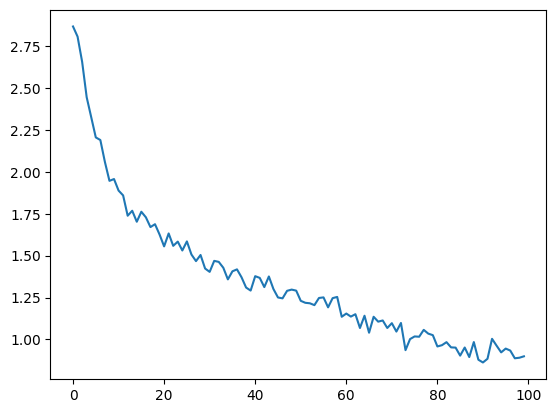

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 评估结果
为了查看网络在不同类别上的表现，我们将创建一个混淆矩阵，指示每种实际语言（行）网络猜测的语言（列）。为了计算混淆矩阵，大量的样本通过evaluate()函数在网络中运行，该函数与train()函数相同，只是没有反向传播。

/var/folders/z6/xyr54v4n0yv32nvm7h202xyc0000gn/T/ipykernel_92907/2014343748.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/z6/xyr54v4n0yv32nvm7h202xyc0000gn/T/ipykernel_92907/2014343748.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


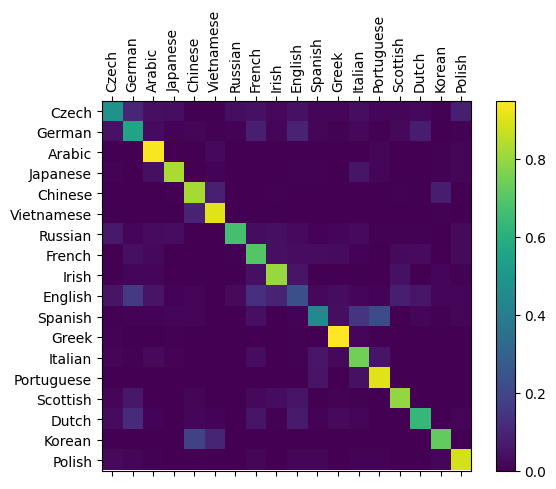

In [50]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

您可以从主轴上找出亮点，这些亮点表明了它猜测错误的语言，例如，将中文误认为韩语，将西班牙语误认为意大利语。它似乎在希腊语方面做得很好，而在英语方面做得非常差（可能是因为它与其他语言重叠）。

## 运行用户输入

In [51]:
def predict(input_line, n_predictions = 3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.42) Russian
(-1.23) Czech
(-3.81) Irish

> Jackson
(-0.15) Scottish
(-2.64) Czech
(-2.89) English

> Satoshi
(-0.70) Japanese
(-1.13) Arabic
(-1.92) Italian
